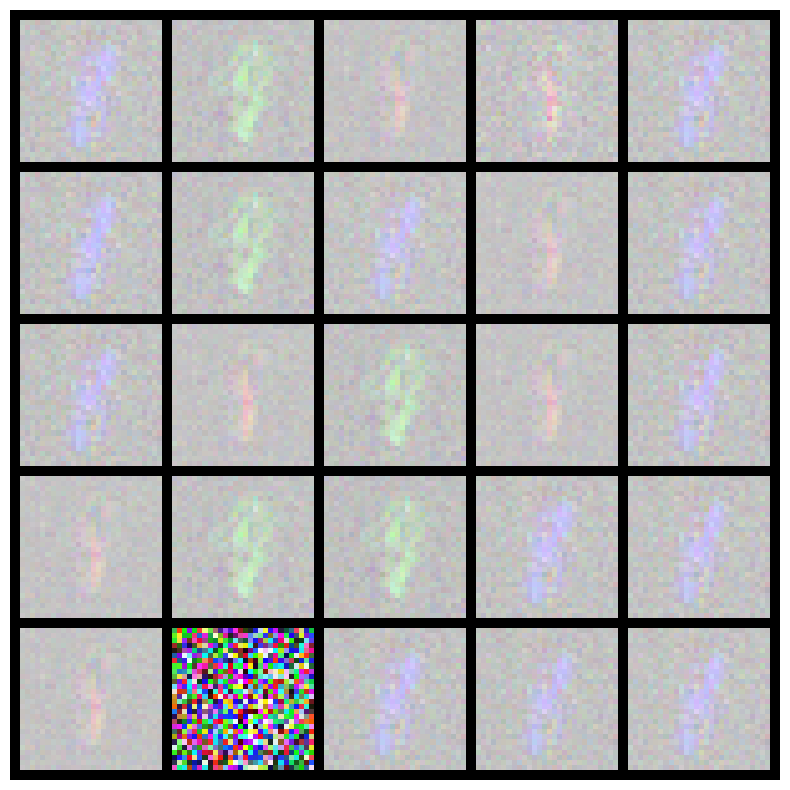

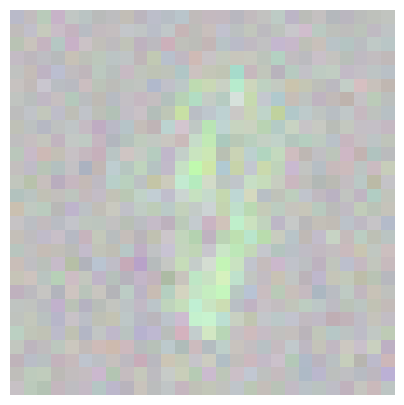

In [9]:
import torch
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np  
from torch import nn
from torchvision import transforms

# 定义生成器类
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        self.color_emb = nn.Embedding(3, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110 + 10, 256), 
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(256),  # 添加BatchNorm层
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(512),  # 添加BatchNorm层
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(1024),  # 添加BatchNorm层
            nn.Linear(1024, 2352),  # 更新此处以适应彩色图像
            nn.Tanh()  # 保持 Tanh 作为最后一层，确保输出值在 [-1, 1] 范围内
        )
    
    def forward(self, z, labels, colors):
        z = z.view(z.size(0), 100)  # 确保输入向量正确展开
        c = self.label_emb(labels)
        color_c = self.color_emb(colors)
        x = torch.cat([z, c, color_c], 1)
        out = self.model(x)      
        return out.view(x.size(0), 3, 28, 28)  # 调整输出维度以匹配三通道彩色图像

# 路径设置
model_dir = '/root/autodl-tmp/xin/GAN/CGAN/model'
save_dir = '/root/autodl-tmp/xin/GAN/CGAN/generator_state-images'

# 确保保存目录存在
os.makedirs(save_dir, exist_ok=True)

# 加载生成器模型
generator = Generator().cuda()
generator.load_state_dict(torch.load(os.path.join(model_dir, 'generator_state_hun82_100epch.pt')))
generator.eval()

# 生成图像函数
def generate_images(generator, num_images, save_dir, labels=None, colors=None):
    z = torch.randn(num_images, 100).cuda()
    if labels is None:
        labels = torch.LongTensor(np.random.randint(0, 10, num_images)).cuda()
    if colors is None:
        colors = torch.LongTensor(np.random.randint(0, 3, num_images)).cuda()
    
    with torch.no_grad():
        images = generator(z, labels, colors).cpu()
        images = 0.5 * images + 0.5  # 反归一化以将图像值调整到 [0, 1] 范围

    # 保存生成的图像
    for i, img in enumerate(images):
        img_pil = transforms.ToPILImage()(img)
        img_pil.save(os.path.join(save_dir, f'generated_{i}_label_{labels[i].item()}_color_{colors[i].item()}.png'))

    # 显示生成的图像
    grid = make_grid(images, nrow=5, normalize=False)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.show()

# 生成并保存图像
generate_images(generator, num_images=25, save_dir=save_dir)

# 单独生成一个指定标签和颜色的图像
def generate_specific_image(generator, digit, color, save_path):
    z = torch.randn(1, 100).cuda()
    label = torch.LongTensor([digit]).cuda()
    color = torch.LongTensor([color]).cuda()
    
    with torch.no_grad():
        img = generator(z, label, color).cpu()
        img = 0.5 * img + 0.5  # 反归一化以将图像值调整到 [0, 1] 范围
        img_pil = transforms.ToPILImage()(img[0])
        img_pil.save(save_path)

    # 显示生成的图像
    plt.figure(figsize=(5, 5))
    plt.imshow(img_pil)
    plt.axis('off')
    plt.show()

# 生成并保存一个指定标签和颜色的图像
specific_save_path = os.path.join(save_dir, 'specific_generated.png')
generate_specific_image(generator, digit=8, color=1, save_path=specific_save_path)


In [ ]:
#记录原始Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        self.color_emb = nn.Embedding(3, 10)  # 假设有4种颜色

        self.model = nn.Sequential(
            nn.Linear(2352 + 10 +10, 1024),  # 调整输入大小为图像大小加上标签和颜色嵌入
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels,colors):
        x = x.view(x.size(0), -1)  # 改为自动计算输入张量的维度
        clabel = self.label_emb(labels)
        color_clabel = self.color_emb(colors)
        x = torch.cat([x, clabel, color_clabel], 1)
       
        out = self.model(x)
       
        return out.squeeze()
 

生成一个合成数据集，生成一共27090张图片，0到9 10个数字，各生成2709张图片，且每个数字内的颜色数量都是一样的，比如说，0这个数字里，生成903张红色，903张蓝色，903张绿色的图片

In [4]:
import torch
import numpy as np
import os
from torchvision import transforms
import csv
import torch
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
from PIL import Image
  
from torch import nn
from torchvision import transforms

# 定义生成器类
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        self.color_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110 + 10, 256), 
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(256),  # 添加BatchNorm层
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(512),  # 添加BatchNorm层
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(1024),  # 添加BatchNorm层
            nn.Linear(1024, 2352),  # 更新此处以适应彩色图像
            nn.Tanh()  # 保持 Tanh 作为最后一层，确保输出值在 [-1, 1] 范围内
        )
    
    def forward(self, z, labels, colors):
        z = z.view(z.size(0), 100)  # 确保输入向量正确展开
        c = self.label_emb(labels)
        color_c = self.color_emb(colors)
        x = torch.cat([z, c, color_c], 1)
        out = self.model(x)      
        return out.view(x.size(0), 3, 28, 28)  # 调整输出维度以匹配三通道彩色图像

# 路径设置
model_dir = '/root/autodl-tmp/xin/Model-Bias-in-Training-with-Generated-Data/CGAN/model'
csv_dir= '/root/autodl-tmp/xin/GAN/CGAN/data'
 
def generate_dataset(generator, num_images_per_digit=2709, save_dir='/root/autodl-tmp/xin/GAN/CGAN/data/generated-second-new-syn-dataset'):
    os.makedirs(save_dir, exist_ok=True)
    
    num_colors = 3  # 假设颜色编号为0=红色, 1=蓝色, 2=绿色
    num_images_per_color = num_images_per_digit // num_colors
    
    # 准备写入CSV文件
    csv_path = os.path.join(csv_dir, 'syn0605-dataset-labels-colors.csv')
    with open(csv_path, 'w', newline='') as csvfile:
        fieldnames = ['image_name', 'label', 'color']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for digit in range(10):  # 对每个数字进行循环
            for color in range(num_colors):  # 对每种颜色进行循环
                for i in range(num_images_per_color):
                    z = torch.randn(1, 100).cuda()
                    label = torch.LongTensor([digit]).cuda()
                    color_label = torch.LongTensor([color]).cuda()

                    with torch.no_grad():
                        img = generator(z, label, color_label).cpu()
                        img = 0.5 * img + 0.5  # 反归一化
                        img_pil = transforms.ToPILImage()(img[0])
                        # 文件名格式
                        filename = f'colored_{digit}_{color}_{i}.png'
                        img_pil.save(os.path.join(save_dir, filename))
                        
                        # 写入CSV
                        writer.writerow({'image_name': filename, 'label': digit, 'color': color})

model_dir = "/root/autodl-tmp/xin/Model-Bias-in-Training-with-Generated-Data/CGAN/model"

# 加载生成器模型
generator = Generator().cuda()
generator.load_state_dict(torch.load(os.path.join(model_dir, 'generator_state100epch.pt')))
generator.eval()

# 生成数据集并保存到CSV
generate_dataset(generator)


RuntimeError: Error(s) in loading state_dict for Generator:
	size mismatch for color_emb.weight: copying a param with shape torch.Size([3, 10]) from checkpoint, the shape in current model is torch.Size([10, 10]).

创建新的数据集  8:2

# 路径设置 first generation
original_data_path = '/root/autodl-tmp/xin/datasets/MNIST/updated_train_labels_with_colors.csv'
original_images_dir = '/root/autodl-tmp/xin/datasets/MNIST/colored-train-images'
generated_data_path = '/root/autodl-tmp/xin/GAN/CGAN/data/generateddata_labels_colors.csv'
generated_images_dir = '/root/autodl-tmp/xin/GAN/CGAN/data/generated-new-syn-dataset'
save_path = '/root/autodl-tmp/xin/GAN/CGAN/data/mixed_images82firstgen.csv'
new_images_dir = '/root/autodl-tmp/xin/GAN/CGAN/data/mixed_images82firstgen'



In [3]:
# 路径设置 second generation
original_data_path = '/root/autodl-tmp/xin/GAN/CGAN/data/mixed_images82firstgen.csv'
original_images_dir = '/root/autodl-tmp/xin/GAN/CGAN/data/mixed_images82firstgen'
generated_data_path = '/root/autodl-tmp/xin/GAN/CGAN/data/second-new-syn-dataset-labels-colors.csv'
generated_images_dir = '/root/autodl-tmp/xin/GAN/CGAN/data/generated-second-new-syn-dataset'
save_path = '/root/autodl-tmp/xin/GAN/CGAN/data/mixed_images82secondgen.csv'
new_images_dir = '/root/autodl-tmp/xin/GAN/CGAN/data/mixed_images82secondgen'



In [4]:
import pandas as pd
import numpy as np
import os
import shutil
import math


# 确保新图片目录存在
os.makedirs(new_images_dir, exist_ok=True)

# 加载数据
original_df = pd.read_csv(original_data_path)
generated_df = pd.read_csv(generated_data_path)

# 保证混合的均匀性，可以按类别和颜色混合
mixed_df = pd.DataFrame()


for digit in range(10):
    for color in range(3):  # 假设颜色编码为0, 1, 2
        # 从原始数据中抽取数据
        original_subset = original_df[(original_df['label'] == digit) & (original_df['color'] == color)]
        original_sample = original_subset.sample(n=1446, random_state=1)  # 确保抽样可以复现

        # 从生成数据中抽取数据
        generated_subset = generated_df[(generated_df['label'] == digit) & (generated_df['color'] == color)]
        generated_sample = generated_subset.sample(n=361, random_state=1)  # 确保抽样可以复现

        # 合并样本
        mixed_sample = pd.concat([original_sample, generated_sample])
        mixed_df = pd.concat([mixed_df, mixed_sample])

        # 复制文件
        original_images = set(original_sample['image_name'])
        for _, row in mixed_sample.iterrows():
            source_dir = original_images_dir if row['image_name'] in original_images else generated_images_dir
            src_file = os.path.join(source_dir, row['image_name'])
            dst_file = os.path.join(new_images_dir, row['image_name'])
            shutil.copy(src_file, dst_file)


            
# 打乱数据顺序
mixed_df = mixed_df.sample(frac=1).reset_index(drop=True)

# 保存到新的CSV文件
mixed_df.to_csv(save_path, index=False)


In [6]:
import pandas as pd

# 加载CSV文件
csv_path = '/root/autodl-tmp/xin/GAN/CGAN/data/mixed_images82secondgen.csv'
data = pd.read_csv(csv_path)

# 统计每个数字的总图片数
total_counts = data['label'].value_counts().sort_index()
print("总图片数每个数字:")
print(total_counts)

# 统计每个数字中每种颜色的图片数
color_counts = data.groupby('label')['color'].value_counts().unstack(fill_value=0)
print("\n每个数字中每种颜色的图片数:")
print(color_counts)


总图片数每个数字:
label
0    5421
1    5421
2    5421
3    5421
4    5421
5    5421
6    5421
7    5421
8    5421
9    5421
Name: count, dtype: int64

每个数字中每种颜色的图片数:
color     0     1     2
label                  
0      1807  1807  1807
1      1807  1807  1807
2      1807  1807  1807
3      1807  1807  1807
4      1807  1807  1807
5      1807  1807  1807
6      1807  1807  1807
7      1807  1807  1807
8      1807  1807  1807
9      1807  1807  1807
